In [3]:
import torch.nn as nn
import torch_geometric.nn as nng
import torch
import random
#from torch_geometric.utils import add_self_loops #ADDED!
import torch.nn.functional as F #ADDED

from typing import List, Optional, Tuple, Union
import torch.nn.functional as F
from torch import Tensor
# from torch.nn import LSTM
# from torch_sparse import SparseTensor, matmul
# from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size
import torchvision.ops

from torch_geometric.data import Data, DataLoader, DataListLoader
# from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np

In [4]:
# Build the network as described in (https://github.com/cfl-minds/gnn_laminar_flow)
# but using pyTorch

class swish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
    def forward(self, x):
        return x * torch.sigmoid(x)

#################################
## InvariantEdgeConv CLASS DEF ##
#################################
#@title InvariantEdgeConv codes, with node_attr_num and edge_attr_num
class InvariantEdgeConv(nng.conv.MessagePassing): #InvariantEdgeConv(nng.conv.GCNConv):
    '''Convolutions class as described in paper, built on GCNConv, 
    with SGCN and FVnew adaptations'''
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        #aggr: Optional[Union[str, List[str], Aggregation]] = 'add',

        old_mlp_ief: int = 0, #paper: previous edge feature dimension
        mlp_hs: int = 128, #paper: two MLPs with hidden size 128 used
        mlp_ief: int = 1, #paper: one MLP with intermediate edge feature dimension fe
        
        node_attr_num: int = 0, #FVnew: number of persistent node_attr
        edge_attr_num: int = 0, #FVnew: number of edge_attr + rel_node_attr
        hidden_size: int = 0, #sGCN: convolution internal hidden size
        dropout: float = 0, #sGCN: dropout
        **kwargs
    ):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels + node_attr_num
        self.out_channels = out_channels
        
        #paper####
        # self.mlp_message = nng.MLP([in_channels*2+old_mlp_ief, mlp_hs, mlp_ief],act='swish', bias=True)
        # self.mlp_update = nng.MLP([mlp_ief+in_channels, mlp_hs, out_channels],act='swish', bias=True)
        self.mlp_message = torchvision.ops.MLP(in_channels*2+old_mlp_ief, [mlp_hs, mlp_ief], \
                                               activation_layer=swish, bias=True)
        self.mlp_update = torchvision.ops.MLP(mlp_ief+in_channels, [mlp_hs, out_channels], \
                                              activation_layer=swish, bias=True)
        # self.mlp_message = torchvision.ops.MLP(in_channels*2+old_mlp_ief, [mlp_hs, mlp_ief], \
        #                                        activation_layer=None, bias=True)
        # self.mlp_update = torchvision.ops.MLP(mlp_ief+in_channels, [mlp_hs, out_channels], \
        #                                       activation_layer=None, bias=True)
        self.new_edge_features = None #torch.tensor([0.])

        #FVnew or sGCN####
        # self.lin_in = torch.nn.Linear(edge_attr_num, hidden_size * in_channels)
        # self.lin_out = torch.nn.Linear(hidden_size * in_channels, out_channels)
        # self.dropout = dropout ####

    #def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
    def forward(self, x, edge_index, edge_feat=None, edge_attr=None, node_attr=None):

        if (node_attr is not None): #for FVnew
            x = torch.cat((x,node_attr),dim=1) #persistent node_attr.

        # if edge_feat is None: #for paper: previous edge feat added if existent
        #     edge_feat = torch.zeros((edge_index.size(1),1))
        out = self.propagate(x=x, edge_index=edge_index, edge_feat=edge_feat, edge_attr=edge_attr) #for FVnew

        return out, self.new_edge_features

    #def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
    #   return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j
    def message(self, x_j, x_i, edge_feat, edge_attr=None):
        """
        x_j [num_edges, label_dim]
        x_i [num_edges, label_dim]
        edge_attr [num_edges, #attr] or none ##ADDED
        """
        symmetric = (x_j + x_i)/2 #paper: symmetric node features
        asymmetric = abs(x_j - x_i)/2 #instead of raw features x_j and x_i
        if edge_feat is not None:
            new_edge_feat = torch.cat((symmetric,asymmetric,edge_feat),dim=1)
        else:
            new_edge_feat = torch.cat((symmetric,asymmetric),dim=1)
        message = self.mlp_message(new_edge_feat)
        # message = message * F.sigmoid(message) #MLP swish activation if act was None
        self.new_edge_features = message

        ##for FVnew ####
        # if edge_attr is not None: 
        #   scaling = F.relu(self.lin_in(edge_attr))  # [n_edges, hidden_size * in_channels]
        # else:
        #   scaling = torch.ones(x_j.size()).unsqueeze(-1).to(x_j.device)
        # n_edges = x_j.size(0)
        # # [n_edges, in_channels, ...] * [n_edges, in_channels, 1]
        # result = scaling.reshape(n_edges, self.in_channels, -1) * message.unsqueeze(-1)
        ####

        return message #result.view(n_edges, -1)

    #def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
    #    return spmm(adj_t, x, reduce=self.aggr)

    def update(self, aggr_out, x):
        """
        x_j [num_nodes, label_dim, 1]
        aggr_out [num_nodes, label_dim, out_channels]
        """
        aggr_out = torch.cat((x,aggr_out),dim=1) #paper
        aggr_out = self.mlp_update(aggr_out)
        # aggr_out = aggr_out * F.sigmoid(aggr_out) #MLP swish activation if act was None

        ##for sGCN ####
        # aggr_out = self.lin_out(aggr_out)  #[num_nodes, label_dim, out_features]
        # aggr_out = torch.tanh(aggr_out); #aggr_out = F.relu(aggr_out)
        # aggr_out = F.dropout(aggr_out, p=self.dropout, training=self.training)
        ####

        return aggr_out
    
# Build the network as described in (https://github.com/cfl-minds/gnn_laminar_flow)
# but using pyTorch

###############################
### EdgeSmoothing CLASS DEF ###
###############################
#@title EdgeSmoothing layer codes
class EdgeSmoothing(nng.conv.MessagePassing): #EdgeSmoothing(nng.conv.GCNConv):
    '''Convolutions class as described in paper, built on GCNConv, 
    with SGCN and FVnew adaptations'''
    def __init__(self,**kwargs):
        kwargs.setdefault('aggr', 'mean')
        super().__init__(**kwargs)

    #def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
    def forward(self, x, edge_index):

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        #out = self.propagate(edge_index, x=x, edge_weight=edge_weight, size=None)
        out = self.propagate(edge_index=edge_index, x=x) #for FVnew

        return out

    #def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
    #   return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j
    def message(self, x_j, x_i, edge_feat=None, edge_attr=None):
        """
        x_j [num_edges, label_dim]
        x_i [num_edges, label_dim]
        """
        symmetric = (x_j + x_i)/2 #paper: symmetric node features
        return symmetric

    #def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
    #    return spmm(adj_t, x, reduce=self.aggr)

    def update(self, aggr_out, x_j):
        """
        aggr_out [num_nodes, label_dim, out_channels]
        """
        return aggr_out
    
##################################
## InvariantEdgeModel CLASS DEF ##
##################################
#@title InvariantEdgeModel codes
#https://github.com/cfl-minds/gnn_laminar_flow/blob/main/network_utils.py#L22
class InvariantEdgeModel(nn.Module):
    def __init__(self, input_size=3, input_edge_feat=3, edge_feature_dim=[4,8,16,32,64,64,32,16], \
                 num_filters=[8,16,32,64,64,32,16,8], output_size=3, \
                 node_attr_num=0, edge_attr_num=0, FV_hidden_size=0):
        super().__init__()

        num_filters = [input_size-2] + num_filters
        edge_feature_dim = [input_edge_feat] + edge_feature_dim
        #increase layer input channel size by 2 because of skip links
        self.layers = [InvariantEdgeConv(in_channels = num_filters[i]+2, 
                                         out_channels = num_filters[i+1],
                                         old_mlp_ief = edge_feature_dim[i],
                                         mlp_hs = 128,
                                         mlp_ief = edge_feature_dim[i+1],
                                         node_attr_num = node_attr_num,
                                         edge_attr_num = edge_attr_num,
                                         hidden_size = FV_hidden_size, 
                                         dropout = 0) \
                       for i in range(len(num_filters)-1)]
        self.layers = torch.nn.ModuleList(self.layers)

        self.smooth_layer = EdgeSmoothing()
        self.final_layer = Linear(num_filters[-1]+2, output_size, bias=True)

    def forward(self, data): #just data input for DataParallel from listloader
        x = data.x.clone()
        x_0 = data.x.clone()[:,0:2] #the coordinate data for skip links
        edge_feat = x[data.edge_index,:].mean(0) #size Ex3 or Ex12
        #edge_feat = None #if no initial edge features

        for layer in self.layers:
            x,edge_feat = layer(x, data.edge_index, edge_feat=edge_feat, edge_attr=None, node_attr=None)
            x = self.smooth_layer(x, data.edge_index)
            x = torch.cat((x_0,x),dim=1) #skip links

        x = self.final_layer(x)

        return x, data.y

In [5]:
# define training function
# https://github.com/cfl-minds/gnn_laminar_flow/blob/main/training.py
# https://github.com/cfl-minds/gnn_laminar_flow/blob/main/training_utils.py

##############################
### IVEModelfit CLASS DEF ####
##############################
#@title IVEModelfit CLASS: fit() func
class IVEModelfit:
    def __init__(self, input_size=3, input_edge_feat=0, edge_feature_dim=[4,8,16,32,64,64,32,16], \
                 num_filters=[8,16,32,64,64,32,16,8], output_size=3, \
                 node_attr_num=0, edge_attr_num=0, FV_hidden_size=0, dropout=0, device='cuda:0'):
        self.model = InvariantEdgeModel(input_size = input_size,
                                        input_edge_feat = input_edge_feat,
                                        edge_feature_dim=edge_feature_dim,
                                        num_filters=num_filters,
                                        output_size = output_size,
                                        node_attr_num=0, edge_attr_num=0, FV_hidden_size=0)
        # if torch.cuda.device_count() > 1:
        #     self.model = nn.DataParallel(self.model)
        self.model.to(device); self.device=device; self.mean,self.var = None,None
        # self.tb = SummaryWriter() #tensorboard --logdir=runs

    def fit(self, path, dataset, valset, max_epoch=1000, bs=64, lr=0.002, weight_decay=0.002, verbose=True):
        criterion = nn.L1Loss().to(self.device);
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=0)
        lambda1 = lambda epoch: 1/(1+epoch*weight_decay) #decay rate is weight decay
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1) #lr is lr0*lambda1
        
        self.model.train() #force dropouts to occur.
        start=time.time(); #print(self.model);
        # self.tb = SummaryWriter() #TensorBoard to show progress
        scaler = torch.cuda.amp.GradScaler() #ADDED: half pres

        #for epoch in range(max_epoch):
        epoch = 0; early_stop = 0; min_val_loss = torch.inf
        while epoch < max_epoch:
            running_loss=0; num_batches=0
            # create minibatches
            trainLoader = DataLoader(dataset, batch_size=bs, shuffle=True)
            #trainLoader = DataListLoader(dataset, batch_size=bs, shuffle=True)

            for batch_list in trainLoader:
              #batch = batch.to(self.device)
              optimizer.zero_grad() #ADDED

              # do one step of stochastic gradient descent: U=U-lr(dL/dU)
              with torch.cuda.amp.autocast(): #ADDED: half pres
                  batch_list = batch_list.to(self.device)
                  outputs, GTy = self.model(batch_list)
                  loss = criterion(outputs, GTy)

              scaler.scale(loss).backward() #ADDED: half pres
              nn.utils.clip_grad_norm_(self.model.parameters(), 5) #if nan loss!
              scaler.step(optimizer) #ADDED: half pres
              scaler.update() #ADDED: half pres

              # add the loss of this batch to the running loss
              running_loss += loss.detach().item(); num_batches+=1

            # compute stats for the full training set
            scheduler.step() #anneal lr
            total_loss = running_loss/num_batches; elapsed = time.time()-start
            # self.tb.add_scalar("Loss/Epoch", total_loss, epoch) #TB plot loss

            if verbose & (epoch%5 == 0):
                #print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
                print('epoch=',epoch,'\t time=',elapsed,'\t loss=',total_loss)
            

            # check stats for validation set, for early stopping
            running_loss=0; num_batches=0; 
            valLoader = DataLoader(valset, batch_size=bs, shuffle=True)
            #valLoader = DataListLoader(valset, batch_size=bs, shuffle=True)
            for batch_list in valLoader:
                with torch.cuda.amp.autocast(): #ADDED: half pres
                    batch_list = batch_list.to(self.device)
                    outputs, GTy = self.model(batch_list)
                    loss = criterion(outputs, GTy)
                running_loss += loss.detach().item(); num_batches+=1
            val_loss = running_loss/num_batches
            # self.tb.add_scalar("ValLoss/Epoch", val_loss, epoch) #TB plot loss
            # if not improved in 60 epochs, end training.
            if val_loss < min_val_loss:
                early_stop = 0; min_val_loss = val_loss
                with open(path+'IVEModel_checkpoint_'+str(epoch)+'.txt', 'wb') as f:
                    torch.save(self.model, f) #save model checkpoint
            else:
                early_stop += 1
            epoch = max_epoch+1 if early_stop>=60 else epoch+1

        # self.tb.close #Tensorboard close
        return self

In [ ]:
# # now we load the data and start the training
# # baseline experiment: model01
# # input: x,y,object, output:u,v,p. No FV attributes.

# train_data = torch.load('train.pickle')
# val_data = torch.load('val.pickle')

# path = 'model01/'
# trained = IVEModelfit(input_size = 3,
#                       input_edge_feat = 3,
#                       edge_feature_dim=[4,8,16,32,64,64,32,16],
#                       num_filters=[8,16,32,64,64,32,16,8],
#                       output_size = 3,
#                       node_attr_num=0, edge_attr_num=0, FV_hidden_size=0,
#                       device='cuda:1')
# trained.fit(path, train_data, val_data, max_epoch=1000, bs=64, lr=0.002, weight_decay=0.002, verbose=True)

In [ ]:
# # now we load the data and start the training
# # SAF and dSDF experiment: model02
# # input: x,y,SAF,dSDF, output:u,v,p. No FV attributes.

# train_data = torch.load('train2.pickle')
# val_data = torch.load('val2.pickle')

# path = 'model02/'
# trained = IVEModelfit(input_size = 12,
#                       input_edge_feat = 12,
#                       edge_feature_dim=[4,8,16,32,64,64,32,16],
#                       num_filters=[8,16,32,64,64,32,16,8],
#                       output_size = 3,
#                       node_attr_num=0, edge_attr_num=0, FV_hidden_size=0,
#                       device='cuda:2')
# trained.fit(path, train_data, val_data, max_epoch=1000, bs=64, lr=0.002, weight_decay=0.002, verbose=True)

In [15]:
# train_data = torch.load('train2.pickle')
# val_data = torch.load('val2.pickle')
# test_data = torch.load('test2.pickle')

# train_data_a, val_data_a, test_data_a = [], [], []
# train_data_b, val_data_b, test_data_b = [], [], []

# for data in train_data:
#     data_a, data_b = data.clone(), data.clone()
#     data_a.x = data_a.x[:,0:4]
#     data_b.x = torch.cat((data_b.x[:, :2], data_b.x[:, 4:]), dim=1)
#     train_data_a.append(data_a); train_data_b.append(data_b)
# for data in val_data:
#     data_a, data_b = data.clone(), data.clone()
#     data_a.x = data_a.x[:,0:4]
#     data_b.x = torch.cat((data_b.x[:, :2], data_b.x[:, 4:]), dim=1)
#     val_data_a.append(data_a); val_data_b.append(data_b)
# for data in test_data:
#     data_a, data_b = data.clone(), data.clone()
#     data_a.x = data_a.x[:,0:4]
#     data_b.x = torch.cat((data_b.x[:, :2], data_b.x[:, 4:]), dim=1)
#     test_data_a.append(data_a); test_data_b.append(data_b)

# torch.save(train_data_a,'train2a.pickle')
# torch.save(val_data_a,'val2a.pickle')
# torch.save(test_data_a,'test2a.pickle')

# torch.save(train_data_b,'train2b.pickle')
# torch.save(val_data_b,'val2b.pickle')
# torch.save(test_data_b,'test2b.pickle')

In [4]:
# now we load the data and start the training
# SAF and dSDF experiment: model02a
# input: x,y,SAF output:u,v,p. No FV attributes.

train_data = torch.load('train2a.pickle')
val_data = torch.load('val2a.pickle')

path = 'model02a/'
trained = IVEModelfit(input_size = 4,
                      input_edge_feat = 4,
                      edge_feature_dim=[4,8,16,32,64,64,32,16],
                      num_filters=[8,16,32,64,64,32,16,8],
                      output_size = 3,
                      node_attr_num=0, edge_attr_num=0, FV_hidden_size=0,
                      device='cuda:2')
trained.fit(path, train_data, val_data, max_epoch=1000, bs=64, lr=0.002, weight_decay=0.002, verbose=True)

/home/jessica/anaconda3/envs/airfrans_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


epoch= 0 	 time= 7.576661109924316 	 loss= 0.23263386338949205
epoch= 5 	 time= 45.11993193626404 	 loss= 0.08652285307645798
epoch= 10 	 time= 82.65494275093079 	 loss= 0.08024674445390702
epoch= 15 	 time= 120.00055527687073 	 loss= 0.058654452115297316
epoch= 20 	 time= 156.82948851585388 	 loss= 0.050506462007761
epoch= 25 	 time= 194.2151119709015 	 loss= 0.046168806552886965
epoch= 30 	 time= 231.21813440322876 	 loss= 0.041387344598770144
epoch= 35 	 time= 268.1909668445587 	 loss= 0.03840037629008293
epoch= 40 	 time= 304.4292607307434 	 loss= 0.03694186896085739
epoch= 45 	 time= 341.1556203365326 	 loss= 0.0336808617413044
epoch= 50 	 time= 378.01849818229675 	 loss= 0.03145594775676727
epoch= 55 	 time= 414.663690328598 	 loss= 0.02838341526687145
epoch= 60 	 time= 451.416708946228 	 loss= 0.02594045512378216
epoch= 65 	 time= 487.98496651649475 	 loss= 0.02302228033542633
epoch= 70 	 time= 524.581157207489 	 loss= 0.02230529747903347
epoch= 75 	 time= 561.2471916675568 	 lo

In [ ]:
# now we load the data and start the training
# SAF and dSDF experiment: model02b
# input: x,y,DSDF output:u,v,p. No FV attributes.

train_data = torch.load('train2b.pickle')
val_data = torch.load('val2b.pickle')

path = 'model02b/'
trained = IVEModelfit(input_size = 10,
                      input_edge_feat = 10,
                      edge_feature_dim=[4,8,16,32,64,64,32,16],
                      num_filters=[8,16,32,64,64,32,16,8],
                      output_size = 3,
                      node_attr_num=0, edge_attr_num=0, FV_hidden_size=0,
                      device='cuda:2')
trained.fit(path, train_data, val_data, max_epoch=1000, bs=64, lr=0.002, weight_decay=0.002, verbose=True)

In [5]:
#test and print the test MAE loss

def testIVE(model, dataset, device='cuda:1'):
    model = model.to(device); model.eval()
    criterion = nn.L1Loss().to(device)
    testLoader = DataLoader(dataset, batch_size=1, shuffle=False)
    torch.set_grad_enabled(False)

    running_loss = 0; num_batches = 0
    for batch_list in testLoader:
        batch_list = batch_list.to(device)
        outputs, GTy = model(batch_list)
        loss = criterion(outputs, GTy)
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item(); num_batches+=1

    # compute stats for the full training set
    total_loss = running_loss/num_batches
    torch.set_grad_enabled(True)
    return total_loss

In [8]:
test_data = torch.load('test2a.pickle')
best_model = torch.load('model02a/IVEModel_checkpoint_544.txt', map_location='cuda:2')

test_loss = testIVE(best_model, test_data, device='cuda:2')
print('test_loss: ',test_loss)

model_parameters = filter(lambda p: p.requires_grad, best_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('number of parmeters: ',params)

test_loss:  0.009741720273159444
number of parmeters:  218365


In [9]:
test_data = torch.load('test2b.pickle')
best_model = torch.load('model02b/IVEModel_checkpoint_527.txt', map_location='cuda:2')

test_loss = testIVE(best_model, test_data, device='cuda:2')
print('test_loss: ',test_loss)

model_parameters = filter(lambda p: p.requires_grad, best_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('number of parmeters: ',params)

test_loss:  0.007848618121352046
number of parmeters:  221437


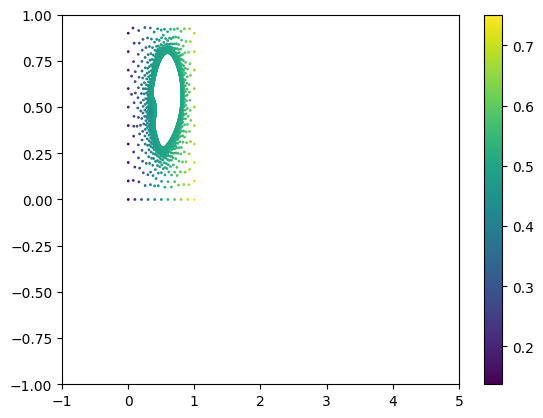

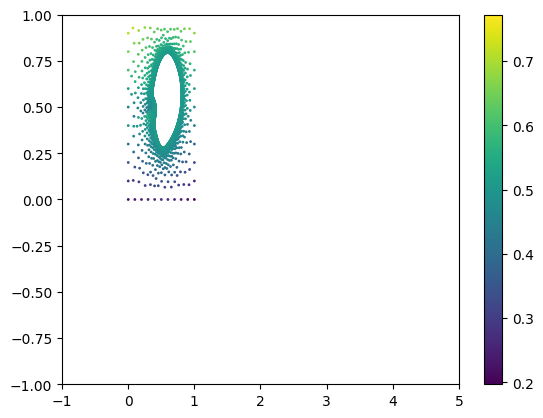

In [7]:
# # train_data = torch.load('train2a.pickle')
# data9 = train_data[0]

# import matplotlib.pyplot as plt

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,2:3])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,3:])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()

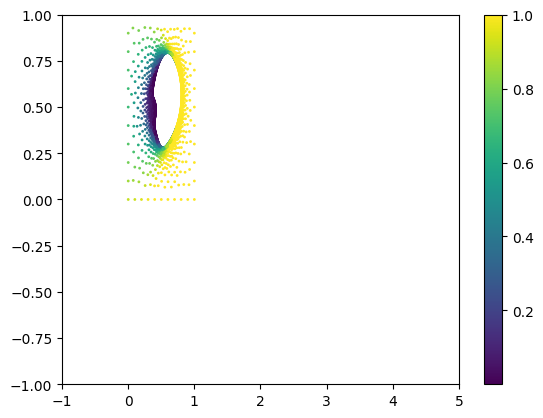

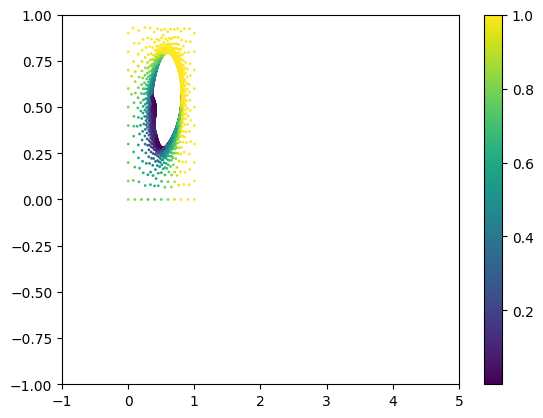

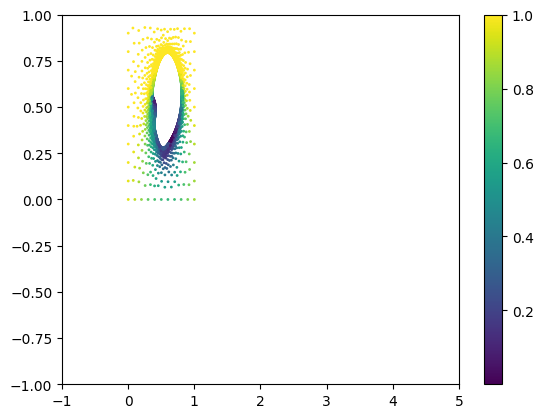

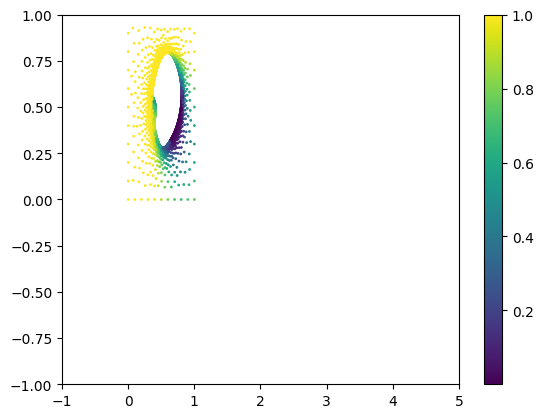

In [8]:
# train_data = torch.load('train2b.pickle')
# data9 = train_data[0]

# import matplotlib.pyplot as plt

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,2:3])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,3:4])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,4:5])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()

# plt.figure()
# plt.scatter(data9.x.cpu()[:,0:1], data9.x.cpu()[:,1:2], s=1, c=data9.x[:,5:6])
# plt.xlim([-1,5]); plt.ylim([-1,1]); plt.colorbar()
# plt.show()